In [1]:
model_name = "linear_hid2_embed32_tanh"
dataset_name = "regress_gaussian"

In [2]:
import train

number of parameters: 0.001185 M 
step 0: train loss 0.4292, val loss 0.3985
step 10: train loss 0.4573, val loss 0.4053
step 20: train loss 0.4213, val loss 0.3899
step 30: train loss 0.4122, val loss 0.3766
step 40: train loss 0.3943, val loss 0.3769
step 50: train loss 0.2517, val loss 0.2755
step 60: train loss 0.1567, val loss 0.2086
step 70: train loss 0.1260, val loss 0.1570
step 80: train loss 0.1237, val loss 0.1522
step 90: train loss 0.1399, val loss 0.1934
step 100: train loss 0.1140, val loss 0.1447
step 110: train loss 0.0969, val loss 0.1260
step 120: train loss 0.0907, val loss 0.1205
step 130: train loss 0.0965, val loss 0.1255
step 140: train loss 0.0807, val loss 0.1054
step 150: train loss 0.0685, val loss 0.0930
step 160: train loss 0.0709, val loss 0.0912
step 170: train loss 0.0695, val loss 0.0967
step 180: train loss 0.0852, val loss 0.1036
step 190: train loss 0.0713, val loss 0.0876
step 200: train loss 0.0667, val loss 0.0859
step 210: train loss 0.0618, val

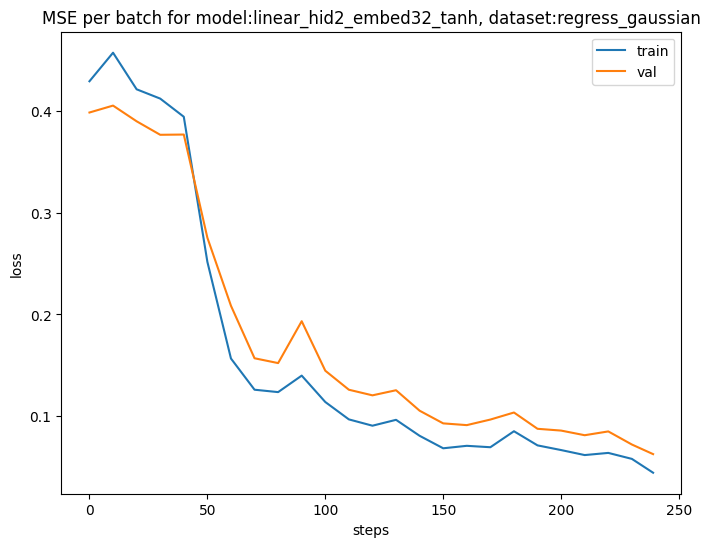

In [3]:
from draw import draw_loss
draw_loss(
    train.iter_list,
    train.train_losses, 
    train.val_losses, 
    f"MSE per batch for model:{model_name}, dataset:{dataset_name}", is_save=True
)

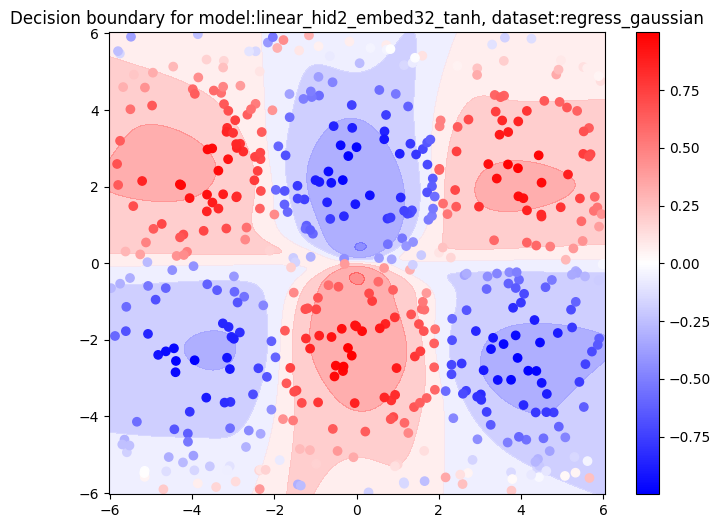

In [4]:
from draw import draw_dataset, draw_decision_boundary
# draw_dataset(train.valset, "Validation set")
draw_decision_boundary(
    train.model, 
    train.valset, 
    f"Decision boundary for model:{model_name}, dataset:{dataset_name}", 
    is_save=True
)